In [119]:
# delete this cell if working on Pycharm
!pip install Bio
!pip install import-ipynb

In [120]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [121]:

import tensorflow as tf
from tensorflow.keras import layers
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

# so we can import utils notebook (delete if working on Pycharm), you might need to change it to your working directory path
%cd "/content/drive/MyDrive/Ex4files" 
import import_ipynb
import utils


/content/drive/MyDrive/Ex4files


In [122]:
###############################################################################
#                                                                             #
#              Parameters you can change, but don't have to                   #
#                                                                             #
###############################################################################

# kernel size for the 1D convolution layer

CONV_1D_SIZE = 11  

# number of ResNet blocks for the first ResNet and the kernel size.

RESNET_1_BLOCKS = 3 
RESNET_1_SIZE = (11, 11)

# learning rate and batch size.
LR = 0.001
BATCH = 32 

###############################################################################
#                                                                             #
#                        Parameters you need to choose                        #
#                                                                             #
###############################################################################


# number of ResNet blocks for the second ResNet, dilation list to repeat and the kernel size.

RESNET_2_BLOCKS = 3  # good start may be 3/5/7
DILATION = [2,2] # was [1]
RESNET_2_SIZE = (3,3)  # good start may be (3,3)/(5,5)/(7,7)

# percentage of dropout for the dropout layer

DROPOUT = 0.1 # good start may be 0.1-0.5

# number of epochs

EPOCHS = 65


In [123]:
def resnet_1(input_layer, n):
    """
    ResNet layer - input -> Conv2D -> Relu -> Conv2D -> BatchNormalization -> Add -> Relu
    :param input_layer: input layer for the ResNet
    :param n: number of ResNet blocks
    :return: last layer of the ResNet
    """
    for i in range(n):
        conv_layer = layers.Conv2D(32, RESNET_1_SIZE, activation="relu", padding='same')(input_layer)
        conv_layer = layers.Conv2D(32, RESNET_1_SIZE, padding='same')(conv_layer)
        batch_layer = layers.BatchNormalization()(conv_layer)
        add_layer = layers.Add()([batch_layer, input_layer])
        input_layer = layers.Activation("relu")(add_layer)

    return input_layer

In [124]:
def resnet_2(input_layer, n, dilation):
    """
    Dilated ResNet layer - input -> dilated Conv2D -> Relu -> dilated Conv2D -> BatchNormalization -> Add -> Relu
    :param input_layer: input layer for the ResNet
    :param n: number of ResNet repetitions
    :param dilation: list of int (for example [1,2,4]), dilation list for each repetition.
    :return: last layer of the ResNet
    """
    for i in range(n):
        conv_layer = layers.Conv2D(64, RESNET_2_SIZE, activation="relu",
                                   padding='same', dilation_rate=dilation)(input_layer)
        conv_layer = layers.Conv2D(64, RESNET_2_SIZE, padding='same')(conv_layer)
        batch_layer = layers.BatchNormalization()(conv_layer)
        add_layer = layers.Add()([batch_layer, input_layer])
        input_layer = layers.Activation("relu")(add_layer)

    return input_layer


In [125]:
def distance_layer(input_layer):
    """
    distance output layer- input -> Conv2D -> Conv2D -> Relu -> combine with transpose
    :param input_layer: keras layer
    :return: distance output layer (32*32*1) with name='distances'
    """
    distances = layers.Conv2D(4, (5,5), padding="same",activation="elu")(input_layer)
    distances = layers.Conv2D(1, (5,5), activation="relu",padding="same")(distances)
    distance_t = layers.Permute((2, 1, 3))(distances)
    distances = layers.Add(name="distances")([0.5 * distances, 0.5 * distance_t])  # for symmetry

    return distances

In [126]:
def theta_layer(input_layer):
    """
    theta output layer- input -> Conv2D -> Conv2D -> tanh
    :param input_layer: keras layer
    :return: theta output layer (32*32*2) with name='thetas'
    """
    thetas = layers.Conv2D(4, (5,5), padding="same", activation="elu")(input_layer)
    thetas = layers.Conv2D(2, (5,5), activation="tanh", padding="same",name="thetas")(thetas)

    return thetas


In [127]:
def omega_layer(input_layer):
    """
    omega output layer- input -> Conv2D -> Conv2D -> tanh -> combine with transpose
    :param input_layer: keras layer
    :return: omega output layer (32*32*2) with name='omegas'
    """
    omegas = layers.Conv2D(4, (5,5), padding="same", activation="elu")(input_layer)
    omegas = layers.Conv2D(2, (5,5), activation="tanh", padding="same",name="omegas")(omegas)

    return omegas

In [128]:
def phi_layer(input_layer):
    """
    phi output layer- input -> Conv2D -> Conv2D -> tanh
    :param input_layer: keras layer
    :return: phi output layer (32*32*2) with name='phis'
    """
    phis = layers.Conv2D(4, (5,5), padding="same", activation="elu")(input_layer)
    phis = layers.Conv2D(2, (5,5), activation="tanh", padding="same",name="phis")(phis)

    return phis

In [129]:
def build_network():
    """
    builds the neural network architecture as shown in the exercise.
    :return: Keras Model
    """
    # input size 32*21
    input_layer = tf.keras.Input(shape=(32, 21), name="InputLayer")

    # Conv1D -> size = 32*32
    conv1d_layer = layers.Conv1D(32, CONV_1D_SIZE, padding='same')(input_layer)
    # reshape, so we can use Conv2D -> size = 32*32*1
    reshape_layer = layers.Reshape((32, 32, 1))(conv1d_layer)

    # Conv2D -> size = 32*32*32
    conv2d_layer = layers.Conv2D(32, RESNET_1_SIZE, padding='same')(reshape_layer)

    # first ResNet -> size = 32*32*32
    resnet_layer = resnet_1(conv2d_layer, RESNET_1_BLOCKS)

    # Conv2D -> size = 32*32*64
    conv2d_layer = layers.Conv2D(64, RESNET_2_SIZE, padding="same")(resnet_layer)

    # second res block: dilated_2d_conv -> relu -> dilated_2d_conv -> batch_normalization -> add -> relu  (size = 32*32*64)
    resnet_layer = resnet_2(conv2d_layer, RESNET_2_BLOCKS, DILATION)

    # dropout -> size = 32*32*64
    dropout_layer = layers.Dropout(DROPOUT)(resnet_layer)

    # distance output -> size = 32*32*1
    distances = distance_layer(dropout_layer)
    # omega output -> size = 32*32*2
    omegas = omega_layer(dropout_layer)
    # theta output -> size = 32*32*2
    thetas = theta_layer(dropout_layer)
    # phi output -> size = 32*32*2
    phis = phi_layer(dropout_layer)

    return tf.keras.Model(input_layer, [distances, omegas, thetas, phis])


In [130]:
def plot_val_train_loss(history):
    """
    plots the train and validation loss of the model at each epoch, saves it in 'model_loss_history.png'
    :param history: history object (output of fit function)
    :return: None
    """
    ig, axes = plt.subplots(1, 4, figsize=(15,3))
    axes[0].plot(history.history['distances_loss'], label='Training loss')
    axes[0].plot(history.history['val_distances_loss'], label='Validation loss')
    axes[0].legend()
    axes[0].set_title("Distance loss")

    axes[1].plot(history.history['omegas_loss'], label='Training loss')
    axes[1].plot(history.history['val_omegas_loss'], label='Validation loss')
    axes[1].legend()
    axes[1].set_title("Omega loss")

    axes[2].plot(history.history['thetas_loss'], label='Training loss')
    axes[2].plot(history.history['val_thetas_loss'], label='Validation loss')
    axes[2].legend()
    axes[2].set_title("Theta loss")

    axes[3].plot(history.history['phis_loss'], label='Training loss')
    axes[3].plot(history.history['val_phis_loss'], label='Validation loss')
    axes[3].legend()
    axes[3].set_title("Phi loss")

    

    plt.savefig("/content/drive/MyDrive/Ex4files/model_loss_history")  # TODO: you can change the path here


In [131]:
def plot_distance_heatmap(true_dist, predicted_dist):
    """
    plots the true and predicted pairwise distances of a nanobody, saves it in 'distance_heatmap.png'
    :param true_dist: true pairwise distance matrix ( n * n * 1)
    :param predicted_dist: predicted pairwise distance matrix ( n * n * 1)
    :return: None
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    sns.heatmap(true_dist[:,:,0],
                ax=axes[0], xticklabels=False,
                yticklabels=False, cbar=True,
                cbar_kws={"shrink": 1, "pad": 0.03, "fraction": 0.04},
                linewidth=0.003, linecolor="#222", cmap="rocket")
    sns.heatmap(predicted_dist[:,:,0],
                ax=axes[1], xticklabels=False,
                yticklabels=False, cbar=True,
                cbar_kws={"shrink": 1, "pad": 0.03, "fraction": 0.04},
                linewidth=0.003, linecolor="#222", cmap="rocket")

    axes[0].set_title("True Distances", fontdict={'fontsize': 18})
    axes[1].set_title("Predicted Distances",fontdict={'fontsize': 18})

    plt.tight_layout()
    plt.savefig("/content/drive/MyDrive/Ex4files/distance_heatmap", dpi=200)  # TODO: you can change the path here



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/65
45/45 [==============================] - 4s 48ms/step - loss: 0.6394 - distances_loss: 0.2224 - omegas_loss: 0.1635 - thetas_loss: 0.1429 - phis_loss: 0.1107 - val_loss: 0.4067 - val_distances_loss: 0.2142 - val_omegas_loss: 0.0660 - val_thetas_loss: 0.0665 - val_phis_loss: 0.0600
Epoch 2/65
45/45 [==============================] - 2s 37ms/step - loss: 0.4047 - distances_loss: 0.2218 - omegas_loss: 0.0670 - thetas_loss: 0.0659 - phis_loss: 0.0500 - val_loss: 0.4137 - val_distances_loss: 0.2142 - val_omegas_loss: 0.0675 - val_thetas_loss: 0.0751 - val_phis_loss: 0.0570
Epoch 3/65
45/45 [==============================] - 2s 37ms/step - loss: 0.3835 - distances_loss: 0.2218 - omegas_loss: 0.0657 - thetas_loss: 0.0564 - phis_loss: 0.0397 - val_loss: 0.3878 - val_distances_loss: 0.2142 - val_omegas_loss: 0.0651 - val_thetas_loss: 0.0616 - val_phis_loss:

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Ex4files/Ex4Output/our_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Ex4files/Ex4Output/our_model/assets


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputLayer (InputLayer)         [(None, 32, 21)]     0                                            
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 32, 32)       7424        InputLayer[0][0]                 
__________________________________________________________________________________________________
reshape_9 (Reshape)             (None, 32, 32, 1)    0           conv1d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_193 (Conv2D)             (None, 32, 32, 32)   3904        reshape_9[0][0]                  
____________________________________________________________________________________________

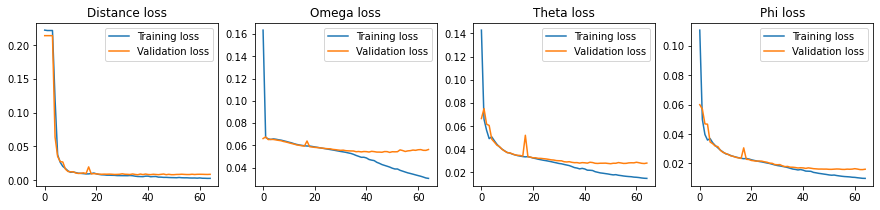

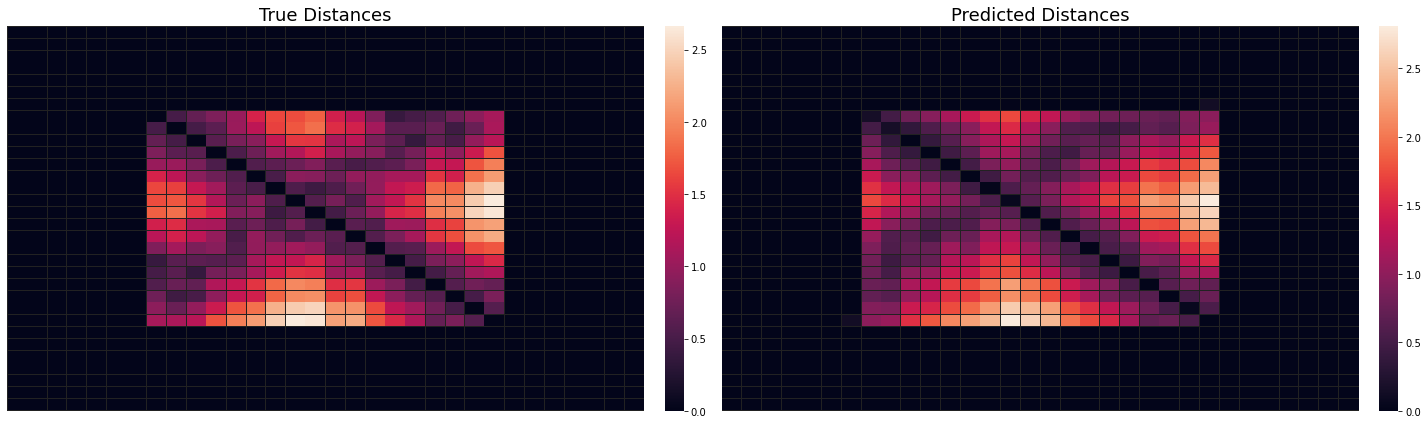

In [132]:
if __name__ == '__main__':

    # imports and etc'
    import pickle
    import numpy as np
    from sklearn.model_selection import train_test_split
    from tensorflow import keras
    drive.mount('/content/drive')
    DATA_PATH = "/content/drive/MyDrive/Ex4files/Ex4Output"

    # loading model

    model = build_network()

    # here your input and output data
    with open(DATA_PATH+'/train_input.pkl','rb') as f:
      X = pickle.load(f)
    with open(DATA_PATH+'/train_dist.pkl', 'rb') as f:
      dist = pickle.load(f)
    with open(DATA_PATH+'/train_omega.pkl', 'rb') as f:
      omega = pickle.load(f)
    with open(DATA_PATH+'/train_theta.pkl', 'rb') as f:
      theta = pickle.load(f)
    with open(DATA_PATH+'/train_phi.pkl', 'rb') as f:
      phi = pickle.load(f)

    with open(DATA_PATH+'/ref_dist.pkl','rb') as f:
      ref_dist = pickle.load(f)
    with open(DATA_PATH+'/ref_input.pkl','rb') as f:
      ref_input = pickle.load(f)


    # split into validation and test sets as you like

    X_train, X_test, dist_train, dist_test, omega_train, omega_test, theta_train, theta_test, phi_train, phi_test = train_test_split(X, dist, omega, theta, phi, test_size=0.33)


    # b)
    #  compile model using Adam optimizer (with learning rate of your choice) and MSE loss.
    opt = tf.keras.optimizers.Adam(learning_rate=LR)
    model.compile(optimizer=opt,loss='mse')

    # c)
    # fit model (use EPOCH for epoch parameter and BATCH for batch_size parameter)
    history = model.fit(X_train, [dist_train, omega_train, theta_train, phi_train], batch_size=BATCH, epochs=EPOCHS, validation_data=(X_test, [dist_test, omega_test, theta_test, phi_test]))
    plot_val_train_loss(history)

    # d)
    # save model
    model.save('/content/drive/MyDrive/Ex4files/Ex4Output/our_model')

    # generate and plot the distance constraints of Nb 5jds using the network you built 

    model.summary()

    ref_input = ref_input.reshape((1,32,21))

    dist_p, omega_p, theta_p, phi_p = model.predict(ref_input)

    dist_p = dist_p.reshape((32,32,1))

    plot_distance_heatmap(ref_dist, dist_p)





